Predictive Modeling

Author: Shray

In [23]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [2]:
def load_file(file):
    """Load flat file to pandas dataframe"""
    return pd.read_csv(file)

In [3]:
def consolidate_data (df1, df2, key = None, left_index=False, right_index=False):
    """perform inner join to return data which is present in both dataframes"""
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

In [4]:
def clean_data(raw_df):
    """remove data which are outliers or duplicates"""
    
    clean_df = raw_df.drop_duplicates(subset ='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

In [5]:
def one_hot_encode_feature_df(df, cat_vars = None, num_vars = None):
    """perform one hot encoding an all categorical varaibles and merge with continous variables"""
    
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    
    return pd.concat([cat_df, num_df], axis = 1)

In [6]:
def get_target(df, target):
    """return target dataframe"""
    
    return df[target]

In [7]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    
    neg_mse = cross_val_score(model, feature_df, target_df, cv = 2, n_jobs = num_procs, scoring= 'neg_mean_squared_error')
    mean_mse[model] = -1.0 * np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

In [8]:
def print_summary(model, mean_mse, cv_std):
    
    print ('\nModel: \n', model)
    print ('Average MSE: \n', mean_mse[model])
    print ('Standard Deviation during CV: \n', cv_std[model])

In [20]:
def save_results(model, mean_mse, predictions, feature_importances):
    """save model, model summary, feature importances, and prediction"""
    
    with open ('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importance.csv')
    np.savetxt('predictions.csv', predictions, delimiter = ',')

In [14]:
#define inputs

train_feature_file = 'train_features.csv'
train_target_file = 'train_salaries.csv'
test_feature_file = 'test_features.csv'

# define variables

cat_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_vars = ['yearsExperience', 'milesFromMetropolis']
target_vars = 'salary'

# Load data

print ("Loading_data")
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

# consolidate training data

raw_train_df =  consolidate_data(feature_df, target_df, key = 'jobId')

# clean the data

clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

# encoding and getting final features

print("Data being encoded")
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars = cat_vars, num_vars = num_vars)
test_df = one_hot_encode_feature_df(test_df, cat_vars = cat_vars, num_vars = num_vars)

# get target df

target_df = get_target(clean_train_df, target_vars)

# starting model list and dicts

models = []
mean_mse = {}
cv_std = {}
res = {}

# number of parallel process

num_procs = 2

#shared model parameters

verbose_lvl = 5

# create models

lr = LinearRegression()

lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())

rf = RandomForestRegressor(n_estimators = 60, n_jobs = num_procs, max_depth = 25, min_samples_split = 60,\
                          max_features = 30, verbose = verbose_lvl)

gbm = GradientBoostingRegressor(n_estimators = 40, max_depth = 5, loss = 'ls', verbose = verbose_lvl)

models.extend([lr, lr_std_pca, rf, gbm])
    

Loading_data
Data being encoded


In [17]:
# Cross validating models and MSE taken as evaluation metrics

print ("Cross Validation Started")

for model in models:
    
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)
    
# Selecting model with lowest MSE

model = min(mean_mse, key = mean_mse.get)
print ('\nPredictions calculated with lowest MSE model:')
print (model)

Cross Validation Started

Model: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE: 
 384.44894477823595
Standard Deviation during CV: 
 0.312732345519521

Model: 
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Average MSE: 
 384.4466837523429
Standard Deviation during CV: 
 0.3192933893919019

Model: 
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=2, oob_score=False, random_state=N

In [21]:
# training on entire daataset

model.fit(feature_df, target_df)

# Create predictions based on test data
predictions = model.predict(test_df)

# Store feature importances

if hasattr(model, 'feature_importance_'):
    importances = model.feature_importances_
else:
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature': feature_df.columns, 'importance': importances})
feature_importances.sort_values(by = 'importance', ascending =  False, inplace = True)

#set index to feature

feature_importances.set_index('feature', inplace = True, drop = True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.0min


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  4.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   18.7s finished


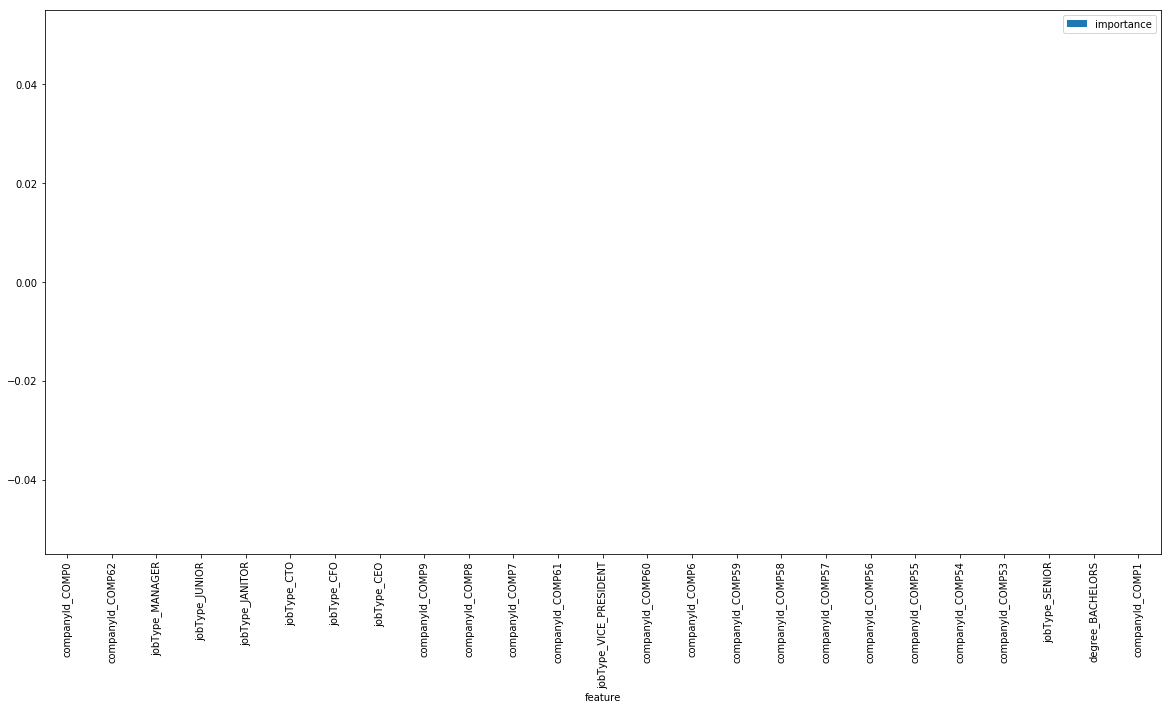

In [24]:
feature_importances[0:25].plot.bar(figsize = (20,10))
plt.show()